In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data_dir = '/content/drive/My Drive/DataSet_1000_for_models/train_set/'
validation_data_dir = '/content/drive/My Drive/DataSet_1000_for_models/validation_set/'
test_data_dir = '/content/drive/My Drive/DataSet_1000_for_models/test_set/'

train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(validation_data_dir, transform=val_transforms)
test_dataset = ImageFolder(test_data_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Custom EfficientWeldNet Architecture for Weld Defect Classification

 This code defines the weldclassnet class, a neural network designed for weld defect classification. It modifies a pre-trained EfficientNet-B1 model by adding custom fully connected layers and a convolutional layer, enhancing its feature extraction and classificatio

In [ ]:
class weldclassnet(nn.Module):
    def __init__(self, num_classes=4):
        super(weldclassnet, self).__init__()
        self.efficientnet = models.efficientnet_b1(pretrained=True)

        # Get the number of features from the last layer
        num_ftrs = self.efficientnet.classifier[1].in_features

        # Modify the classifier
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        # Replace the original classifier
        self.efficientnet.classifier = self.classifier

        # Add a custom layer (e.g., an additional convolutional layer)
        self.custom_conv = nn.Conv2d(1280, 1280, kernel_size=3, padding=1)

    def forward(self, x):
        # Get the features from the EfficientNet layers
        features = self.efficientnet.features(x)

        # Apply the custom convolutional layer
        custom_features = self.custom_conv(features)

        # Global average pooling
        x = self.efficientnet.avgpool(custom_features)

        # Flatten the features
        x = torch.flatten(x, 1)

        # Apply the classifier
        x = self.classifier(x)

        return x

# Model Initialization and Training Setup for WeldClassNet

initializes the WeldClassNet model for weld defect classification and sets up the training parameters, including a cross-entropy loss function, the Adam optimizer, and a learning rate scheduler to reduce the learning rate based on validation performance.

In [ ]:
# Initialize the model
model = weldclassnet(num_classes=4)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 142MB/s]


# Training Function for WeldClassNet Model

This Function implements a training function for the WeldClassNet model, managing both training and validation phases over a specified number of epochs. It tracks losses and accuracies, applies early stopping based on validation loss, and saves the model weights with the best performance. The function also returns the trained model and a history of the training metrics.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Data processing
            for inputs, labels in tqdm(dataloader):
                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                #  backward pass + optimize in case of train
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Copy the best accuracy model
            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Loss: {:4f}'.format(best_loss))

    # Load the best weights into the model
    model.load_state_dict(best_model_wts)

    # Save training history
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }



    return model, history

In [ ]:
# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


100%|██████████| 100/100 [05:42<00:00,  3.42s/it]


train Loss: 1.2855 Acc: 0.5820


100%|██████████| 40/40 [02:32<00:00,  3.82s/it]


val Loss: 0.6792 Acc: 0.7525
Epoch 2/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


train Loss: 0.7310 Acc: 0.7800


100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


val Loss: 0.3323 Acc: 0.8775
Epoch 3/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


train Loss: 0.6356 Acc: 0.8320


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


val Loss: 0.7405 Acc: 0.7300
Epoch 4/20
----------


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


train Loss: 0.5892 Acc: 0.8390


100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


val Loss: 0.3744 Acc: 0.9350
Epoch 5/20
----------


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


train Loss: 0.5563 Acc: 0.8560


100%|██████████| 40/40 [00:08<00:00,  4.50it/s]


val Loss: 0.3814 Acc: 0.9100
Epoch 6/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


train Loss: 0.5570 Acc: 0.8450


100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


val Loss: 0.1941 Acc: 0.9400
Epoch 7/20
----------


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


train Loss: 0.3460 Acc: 0.9150


100%|██████████| 40/40 [00:09<00:00,  4.37it/s]


val Loss: 0.2232 Acc: 0.9400
Epoch 8/20
----------


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


train Loss: 0.3928 Acc: 0.9060


100%|██████████| 40/40 [00:09<00:00,  4.21it/s]


val Loss: 0.2269 Acc: 0.9425
Epoch 9/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


train Loss: 0.3150 Acc: 0.9400


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


val Loss: 0.1678 Acc: 0.9475
Epoch 10/20
----------


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


train Loss: 0.3159 Acc: 0.9170


100%|██████████| 40/40 [00:09<00:00,  4.23it/s]


val Loss: 0.3258 Acc: 0.8550
Epoch 11/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


train Loss: 0.2648 Acc: 0.9340


100%|██████████| 40/40 [00:09<00:00,  4.34it/s]


val Loss: 0.1746 Acc: 0.9650
Epoch 12/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


train Loss: 0.2643 Acc: 0.9300


100%|██████████| 40/40 [00:09<00:00,  4.35it/s]


val Loss: 0.4650 Acc: 0.9275
Epoch 13/20
----------


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


train Loss: 0.2508 Acc: 0.9370


100%|██████████| 40/40 [00:09<00:00,  4.37it/s]


val Loss: 0.3693 Acc: 0.8700
Epoch 14/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


train Loss: 0.2354 Acc: 0.9510


100%|██████████| 40/40 [00:09<00:00,  4.36it/s]


val Loss: 0.5495 Acc: 0.9075
Epoch 15/20
----------


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


train Loss: 0.3203 Acc: 0.9320


100%|██████████| 40/40 [00:09<00:00,  4.24it/s]


val Loss: 0.2970 Acc: 0.9525
Epoch 16/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


train Loss: 0.5814 Acc: 0.8790


100%|██████████| 40/40 [00:09<00:00,  4.27it/s]


val Loss: 0.4725 Acc: 0.8650
Epoch 17/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


train Loss: 0.4923 Acc: 0.8820


100%|██████████| 40/40 [00:09<00:00,  4.39it/s]


val Loss: 0.4587 Acc: 0.9025
Epoch 18/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


train Loss: 0.1510 Acc: 0.9560


100%|██████████| 40/40 [00:09<00:00,  4.37it/s]


val Loss: 0.1760 Acc: 0.9600
Epoch 19/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


train Loss: 0.0888 Acc: 0.9810


100%|██████████| 40/40 [00:08<00:00,  4.49it/s]


val Loss: 0.2035 Acc: 0.9650
Epoch 20/20
----------


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


train Loss: 0.0362 Acc: 0.9890


100%|██████████| 40/40 [00:09<00:00,  4.34it/s]

val Loss: 0.2017 Acc: 0.9650
Best val Loss: 0.167755


#  Visualization of Training and Validation Metrics

generates plots to visualize the training and validation accuracy and loss of the **WeldClassNet** model over epochs. It provides insights into the model's performance, helping to assess learning progress and identify potential issues such as overfitting.

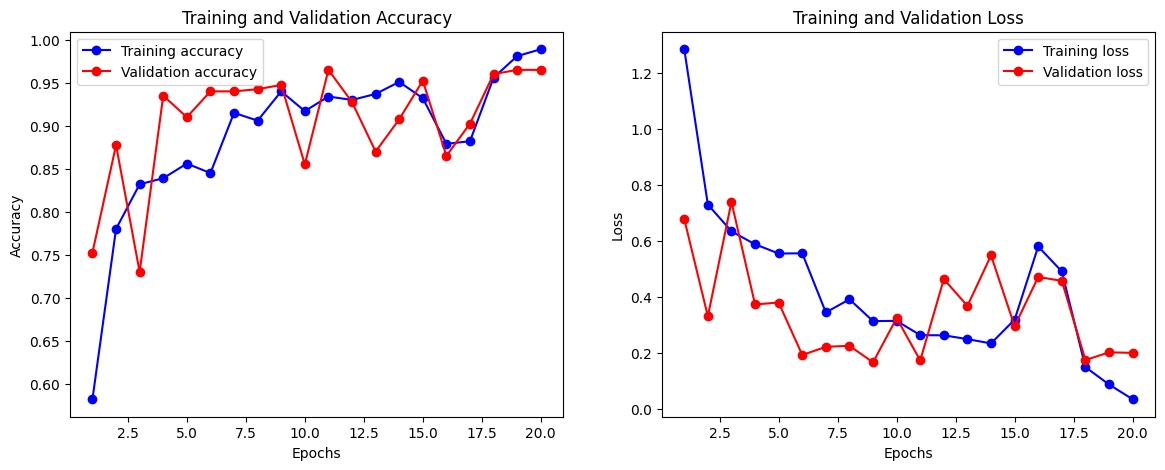

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Model Evaluation Function for WeldClassNet

This Function defines an evaluation function for the **WeldClassNet** model, calculating the total loss and accuracy on specified data loaders. It assesses the model's performance on training, validation, and test datasets, providing essential metrics for performance analysis.

In [ ]:
# Evaluation function
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_accuracy = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_accuracy

# Evaluate the model
train_loss, train_accuracy = evaluate_model(model, train_loader, criterion)
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)


In [ ]:
print(f'Training loss EfficientWeldNet model  : {train_loss:.4f} ... Training accuracy EfficientWeldNet model:   {train_accuracy:.4f}')
print(f'Validation loss EfficientWeldNet model: {val_loss:.4f}   ... Validation accuracy EfficientWeldNet model: {val_accuracy:.4f}')
print(f'Test loss EfficientWeldNet model      : {test_loss:.4f}  ... Test accuracy EfficientWeldNet model:       {test_accuracy:.4f}')

Training loss EfficientWeldNet model  : 0.0039 ... Training accuracy EfficientWeldNet model:   0.9990
Validation loss EfficientWeldNet model: 0.1145   ... Validation accuracy EfficientWeldNet model: 0.9825
Test loss EfficientWeldNet model      : 0.0640  ... Test accuracy EfficientWeldNet model:       0.9850


# Confusion Matrix Visualization for WeldClassNet Evaluation

This code implements a function to plot the confusion matrix for the WeldClassNet model's predictions on a given data loader. It calculates the confusion matrix, normalizes it, and displays it using ConfusionMatrixDisplay, providing insights into the model's classification performance across different classes.

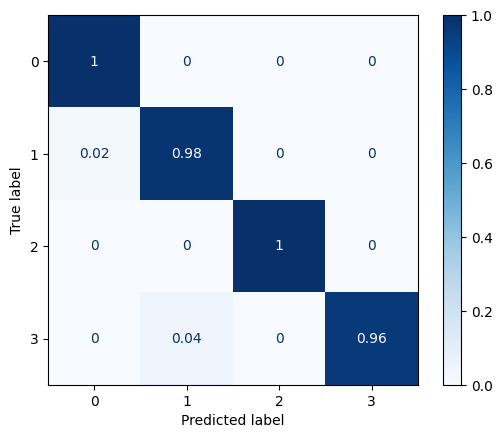

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())


    cm = confusion_matrix(all_labels, all_preds)


    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
    disp.plot(cmap=plt.cm.Blues)

    plt.show()


plot_confusion_matrix(model, test_loader)

